Used in IGANN Paper (Case Study 2)

See IGANN Appendix i:
"The dataset is taken from the FICO Explainable Machine Learning Challenge15. It contains 10,459 samples with 21 continuous features, two categorical features, and a binary target variable stating whether or not an individual defaulted on the loan"

Appendix also highlights preprocessing (keep only 10 features + target)

Link: https://www.kaggle.com/datasets/averkiyoliabev/home-equity-line-of-creditheloc

Alternatives: GAM Coach User Study (eg German Credit)

**TODO: Preprocessing**

In [1]:
import pandas as pd
df_raw = pd.read_csv("heloc_dataset.csv")
df_raw

,RiskPerformance,ExternalRiskEstimate,MSinceOldestTradeOpen,MSinceMostRecentTradeOpen,AverageMInFile,NumSatisfactoryTrades,NumTrades60Ever2DerogPubRec,NumTrades90Ever2DerogPubRec,PercentTradesNeverDelq,MSinceMostRecentDelq,...,PercentInstallTrades,MSinceMostRecentInqexcl7days,NumInqLast6M,NumInqLast6Mexcl7days,NetFractionRevolvingBurden,NetFractionInstallBurden,NumRevolvingTradesWBalance,NumInstallTradesWBalance,NumBank2NatlTradesWHighUtilization,PercentTradesWBalance
0,Bad,55,144,4,84,20,3,0,83,2,...,43,0,0,0,33,-8,8,1,1,69
1,Bad,61,58,15,41,2,4,4,100,-7,...,67,0,0,0,0,-8,0,-8,-8,0
2,Bad,67,66,5,24,9,0,0,100,-7,...,44,0,4,4,53,66,4,2,1,86
3,Bad,66,169,1,73,28,1,1,93,76,...,57,0,5,4,72,83,6,4,3,91
4,Bad,81,333,27,132,12,0,0,100,-7,...,25,0,1,1,51,89,3,1,0,80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10454,Good,73,131,5,57,21,0,0,95,80,...,19,7,0,0,26,-8,5,2,0,100
10455,Bad,65,147,39,68,11,0,0,92,28,...,42,1,1,1,86,53,2,2,1,80
10456,Bad,74,129,6,64,18,1,1,100,-7,...,33,3,4,4,6,-8,5,-8,0,56
10457,Bad,72,234,12,113,42,2,2,96,35,...,20,6,0,0,19,-8,4,1,0,38


Train without preprocessing

In [12]:
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show
from sklearn.model_selection import train_test_split

df_raw["RiskPerformance"] = df_raw["RiskPerformance"].replace({"Bad": 0, "Good": 1})

y = df_raw["RiskPerformance"]
X = df_raw.drop(columns=["RiskPerformance"])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

ebm = ExplainableBoostingClassifier(random_state=42)
ebm.fit(X_train, y_train)
#show(ebm.explain_global())

ExplainableBoostingClassifier()

**Analyze "MSinceMostRecentDelq"**
Feature Index 8

In [17]:
graph = graphs.extract_graph(ebm, 8)
graph_as_text = graphs.graph_to_text(graph)
print(graph_as_text)

INFO: The graph of feature MSinceMostRecentDelq was simplified by 1.2%.
This graph represents a continuous-valued feature. The keys are intervals that represent ranges where the function predicts the same value.

Feature Name: MSinceMostRecentDelq
Feature Type: continuous
Means: {"(-9.0, -7.5)": -0.0086, "(-7.5, -3.5)": -0.0144, "(-3.5, 0.5)": -0.0286, "(0.5, 1.5)": -0.0391, "(1.5, 2.5)": -0.0525, "(2.5, 5.5)": -0.0637, "(5.5, 10.5)": -0.0736, "(10.5, 12.5)": -0.0888, "(12.5, 15.5)": -0.1151, "(15.5, 16.5)": -0.1078, "(16.5, 17.5)": -0.1016, "(17.5, 18.5)": -0.0951, "(18.5, 19.5)": -0.0887, "(19.5, 20.5)": -0.0799, "(20.5, 21.5)": -0.0036, "(21.5, 22.5)": 0.0058, "(22.5, 23.5)": 0.0149, "(23.5, 24.5)": 0.0263, "(24.5, 25.5)": 0.0339, "(25.5, 26.5)": 0.041, "(26.5, 27.5)": 0.0503, "(27.5, 28.5)": 0.0562, "(28.5, 29.5)": 0.0641, "(29.5, 30.5)": 0.075, "(30.5, 31.5)": 0.0897, "(31.5, 32.5)": 0.1203, "(32.5, 33.5)": 0.1302, "(33.5, 34.5)": 0.1455, "(34.5, 35.5)": 0.1553, "(35.5, 36.5)": 0.

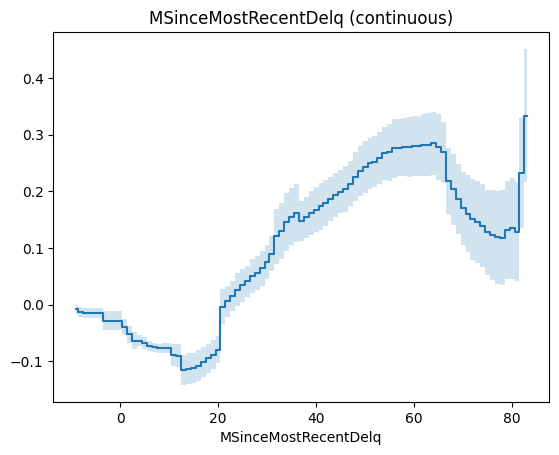

In [18]:
graphs.plot_graph(graph)

***GPT Analysis***

The feature **MSinceMostRecentDelq** (Months Since Most Recent Delinquency) reflects how long it has been since the borrower was last delinquent on a payment. In the context of loan approval, a higher value typically indicates more time has passed since the last delinquency, which is generally seen as a positive sign.

Key domain knowledge contradictions in the shape function:

1. **Negative values for recent delinquencies**: For values close to zero (e.g., the range "(-9.0, -7.5)" to "(2.5, 5.5)"), the function returns negative contributions, which is expected, as recent delinquencies are risky. However, the contributions get **worse** as delinquency becomes more recent, reaching a minimum at "(-9.0, -7.5)", which is inconsistent with the fact that it would be impossible to have a delinquency 9 months in the future.

2. **Improving outcomes with very high values**: The contributions for MSinceMostRecentDelq increase significantly after 20 months (e.g., ranges like "(30.5, 31.5)" or higher). While it makes sense that outcomes improve with more time since the last delinquency, the large positive values beyond 60 months seem unrealistic. The shape function suggests **extreme optimism** for borrowers who have not had a delinquency for several years, even though such borrowers might still have other risk factors.

3. **Inconsistent pattern near 70 months**: After 70 months, the contribution suddenly **drops** (e.g., "(65.5, 66.5)" to "(73.5, 74.5)"). This contradicts the expectation that as time since the last delinquency increases, the likelihood of loan repayment should consistently improve. This drop could indicate a flaw in the data or model.

In summary, the model suggests extreme penalties for very recent delinquencies (including impossible values) and overly optimistic predictions for very old delinquencies. Additionally, the drop near 70 months is unexpected.

In [2]:
import igann_helpers
dataset = igann_helpers.load_fico_data()

In [3]:
X_df = dataset["full"]["X"]
X_df

,ExternalRiskEstimate,MSinceOldestTradeOpen,AverageMInFile,NumSatisfactoryTrades,PercentTradesNeverDelq,MSinceMostRecentDelq,PercentInstallTrades,MSinceMostRecentInqexcl7days,NetFractionRevolvingBurden,NumRevolvingTradesWBalance
0,55.0,144.0,84.0,20.0,83.0,2.000000,43.0,0.0,33.0,8.0
1,61.0,58.0,41.0,2.0,100.0,21.879547,67.0,0.0,0.0,0.0
2,67.0,66.0,24.0,9.0,100.0,21.879547,44.0,0.0,53.0,4.0
3,66.0,169.0,73.0,28.0,93.0,76.000000,57.0,0.0,72.0,6.0
4,81.0,333.0,132.0,12.0,100.0,21.879547,25.0,0.0,51.0,3.0
...,...,...,...,...,...,...,...,...,...,...
10454,73.0,131.0,57.0,21.0,95.0,80.000000,19.0,7.0,26.0,5.0
10455,65.0,147.0,68.0,11.0,92.0,28.000000,42.0,1.0,86.0,2.0
10456,74.0,129.0,64.0,18.0,100.0,21.879547,33.0,3.0,6.0,5.0
10457,72.0,234.0,113.0,42.0,96.0,35.000000,20.0,6.0,19.0,4.0


In [5]:
y_df = dataset["full"]["y"]
y_df

0        0
1        0
2        0
3        0
4        0
        ..
10454    1
10455    0
10456    0
10457    0
10458    0
Name: RiskPerformance, Length: 10459, dtype: int64

In [6]:
X_df["RiskPerformance"] = y_df
X_df

,ExternalRiskEstimate,MSinceOldestTradeOpen,AverageMInFile,NumSatisfactoryTrades,PercentTradesNeverDelq,MSinceMostRecentDelq,PercentInstallTrades,MSinceMostRecentInqexcl7days,NetFractionRevolvingBurden,NumRevolvingTradesWBalance,RiskPerformance
0,55.0,144.0,84.0,20.0,83.0,2.000000,43.0,0.0,33.0,8.0,0
1,61.0,58.0,41.0,2.0,100.0,21.879547,67.0,0.0,0.0,0.0,0
2,67.0,66.0,24.0,9.0,100.0,21.879547,44.0,0.0,53.0,4.0,0
3,66.0,169.0,73.0,28.0,93.0,76.000000,57.0,0.0,72.0,6.0,0
4,81.0,333.0,132.0,12.0,100.0,21.879547,25.0,0.0,51.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...
10454,73.0,131.0,57.0,21.0,95.0,80.000000,19.0,7.0,26.0,5.0,1
10455,65.0,147.0,68.0,11.0,92.0,28.000000,42.0,1.0,86.0,2.0,0
10456,74.0,129.0,64.0,18.0,100.0,21.879547,33.0,3.0,6.0,5.0,0
10457,72.0,234.0,113.0,42.0,96.0,35.000000,20.0,6.0,19.0,4.0,0


In [7]:
X_df.to_csv("heloc_preprocessed.csv")